In [5]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [12]:
#constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS   = 3
EPOCHS = 50
FILE_PATH  = "Pea Plant dataset"

In [13]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory=FILE_PATH,
            shuffle=True,
            image_size=(IMAGE_SIZE,IMAGE_SIZE),
            batch_size = BATCH_SIZE,
)

Found 1432 files belonging to 4 classes.


In [15]:
class_names = dataset.class_names
class_names

['DOWNY_MILDEW_LEAF', 'FRESH_LEAF', 'LEAFMINNER_LEAF', 'POWDER_MILDEW_LEAF']

In [16]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 1 0 1 1 2 2 2 3 0 1 2 3 1 0 2 1 1 1 3 1 2 1 2 1 2 3 2 0]


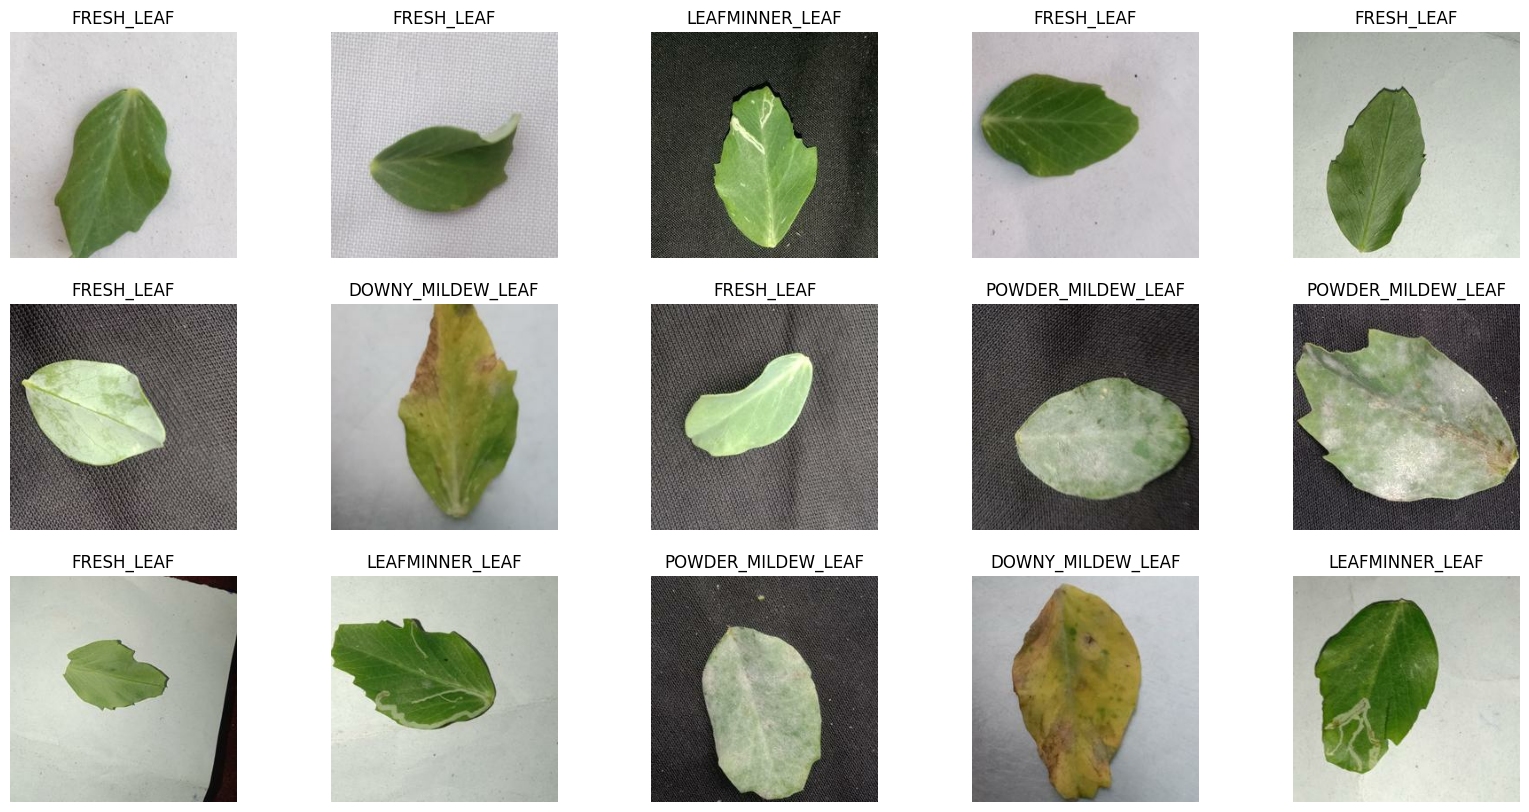

In [17]:
plt.figure(figsize=(20,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [18]:
def get_dataset_partitions(ds,train_split=0.8,test_split=0.1,valid_split=0.1,shuffle=True,shuffle_size=10000):
    assert  train_split+test_split+valid_split==1
    ds_size = len(ds)
    if shuffle:
        ds.shuffle(shuffle_size,seed=12)
    train_size = int(len(ds)*train_split)
    valid_size = int(len(ds)*valid_split)

  
    train_ds = ds.take(train_size)    
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)
    
    return train_ds ,test_ds, valid_ds

In [19]:
train_ds ,test_ds, valid_ds = get_dataset_partitions(dataset)

In [20]:
# performance improving by both using CPU and GPU
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
#Image Preprocessing : Rescaling and Resizing
rescale_and_resize=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE) ,# will resize to the IMAGE_SIZE if there's any issue
    layers.experimental.preprocessing.Rescaling(1./255)  # Normalization
])

In [22]:
#data augmentation

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)


model = models.Sequential([
    rescale_and_resize,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [25]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [26]:
history = model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=valid_ds,
        verbose=1,
        epochs=EPOCHS
    )

Epoch 1/50
36/36 [==============================] - 57s 2s/step - loss: 1.3684 - accuracy: 0.3082 - val_loss: 1.3345 - val_accuracy: 0.3047
Epoch 2/50
36/36 [==============================] - 55s 2s/step - loss: 1.1123 - accuracy: 0.4852 - val_loss: 1.0471 - val_accuracy: 0.5078
Epoch 3/50
36/36 [==============================] - 54s 2s/step - loss: 0.9509 - accuracy: 0.6033 - val_loss: 0.9641 - val_accuracy: 0.5391
Epoch 4/50
36/36 [==============================] - 55s 2s/step - loss: 0.8247 - accuracy: 0.6632 - val_loss: 0.8740 - val_accuracy: 0.6016
Epoch 5/50
36/36 [==============================] - 56s 2s/step - loss: 0.6896 - accuracy: 0.7196 - val_loss: 0.9134 - val_accuracy: 0.5938
Epoch 6/50
36/36 [==============================] - 55s 2s/step - loss: 0.6813 - accuracy: 0.7222 - val_loss: 0.6607 - val_accuracy: 0.6953
Epoch 7/50
36/36 [==============================] - 55s 2s/step - loss: 0.6271 - accuracy: 0.7413 - val_loss: 0.7921 - val_accuracy: 0.6797
Epoch 8/50
36/36 [==

In [27]:
scores = model.evaluate(test_ds)
scores

5/5 [==============================] - 3s 413ms/step - loss: 0.2502 - accuracy: 0.9013


[0.25015273690223694, 0.9013158082962036]

In [28]:
scores

[0.25015273690223694, 0.9013158082962036]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 36}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
history.history['accuracy']

[0.3081597089767456,
 0.4852430522441864,
 0.6032986044883728,
 0.6631944179534912,
 0.7196180820465088,
 0.7222222089767456,
 0.7413194179534912,
 0.7447916865348816,
 0.7647569179534912,
 0.7760416865348816,
 0.7638888955116272,
 0.7881944179534912,
 0.7907986044883728,
 0.8081597089767456,
 0.7934027910232544,
 0.7890625,
 0.8203125,
 0.8055555820465088,
 0.8098958134651184,
 0.8133680820465088,
 0.8333333134651184,
 0.8038194179534912,
 0.8385416865348816,
 0.8376736044883728,
 0.8012152910232544,
 0.8220486044883728,
 0.8420138955116272,
 0.8489583134651184,
 0.7907986044883728,
 0.8107638955116272,
 0.8550347089767456,
 0.8715277910232544,
 0.8689236044883728,
 0.8741319179534912,
 0.8758680820465088,
 0.7170138955116272,
 0.8298611044883728,
 0.8732638955116272,
 0.8567708134651184,
 0.8819444179534912,
 0.9036458134651184,
 0.8932291865348816,
 0.8862847089767456,
 0.8862847089767456,
 0.9123263955116272,
 0.8880208134651184,
 0.9010416865348816,
 0.9166666865348816,
 0.9053819

In [33]:
len(history.history['accuracy'])

50

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

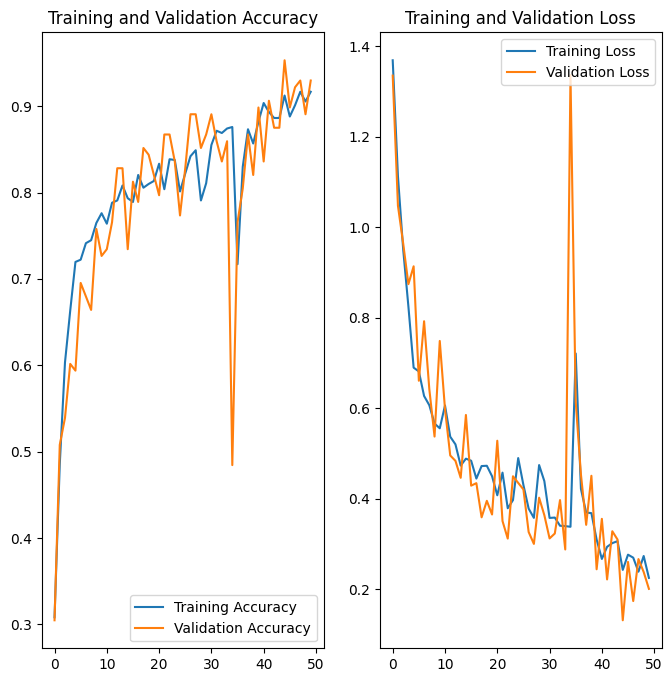

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: POWDER_MILDEW_LEAF
1/1 [==============================] - 1s 721ms/step
predicted label: POWDER_MILDEW_LEAF


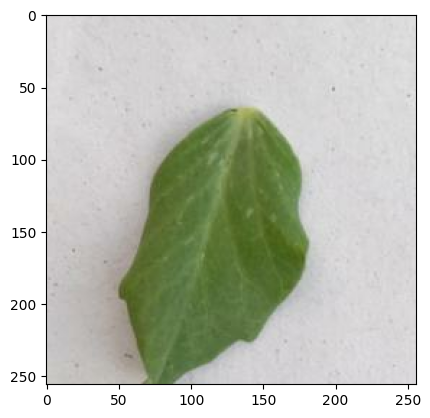

In [36]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
   
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [37]:
def predict_tomato_diseases(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
  

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 62ms/step


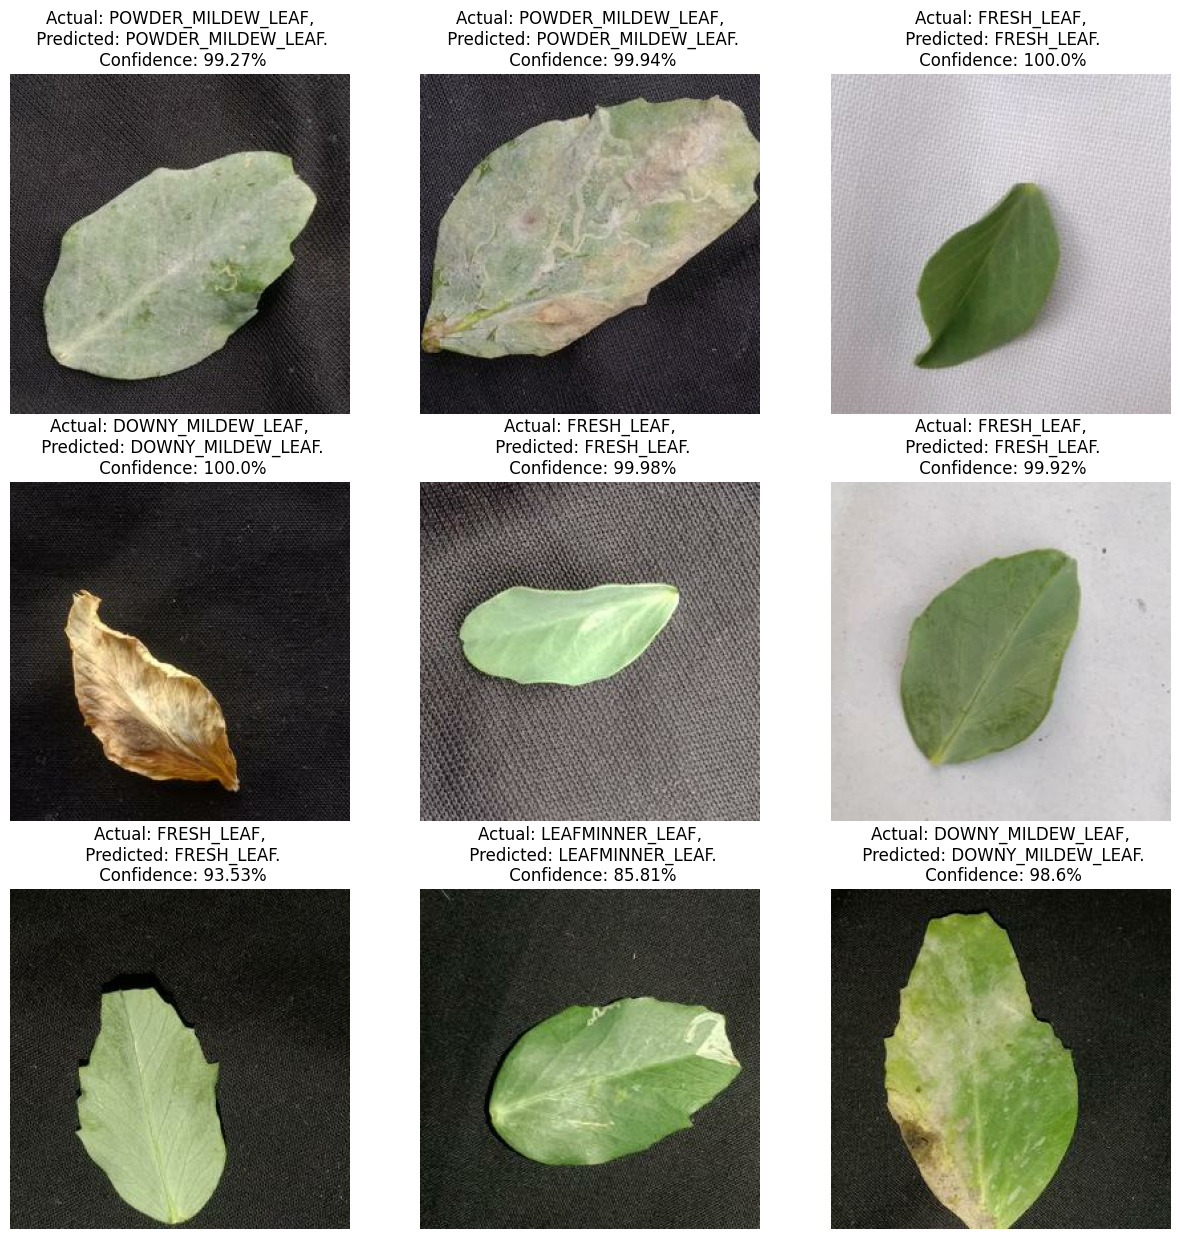

In [38]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict_tomato_diseases(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [32]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets
